In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

%matplotlib widget

def load_data(dir, w, date):
    name = '%sS21_w%d_%s.npy' % (dir, w, date)
    darkname = '%s/S21_w%d_%s_dark.npy' % (dir, w, date)
    freqsname = '%s/S21_w%d_%s_freqs.npy' % (dir, w, date)
    settings = '%s/S21_w%d_%s_settings.txt' % (dir, w, date)
    s21s = np.load(name)
    s21dark = np.load(darkname)
    freqs = np.load(freqsname)
    return s21s, s21dark, freqs

def moving_average_filter(data, window_width):
    cumsum = np.cumsum(data, dtype=float)
    cumsum[window_width:] = cumsum[window_width:] - cumsum[:-window_width]
    result = cumsum[window_width - 1:] / window_width
    result = np.concatenate((np.full(window_width - 1, result[0]), result))
    return result
            
s21s, s21dark, freqs = load_data('S21s/17-10-23/', 3, '13h56_17-10-2023')
print(s21s.shape)



(55, 2, 64020)


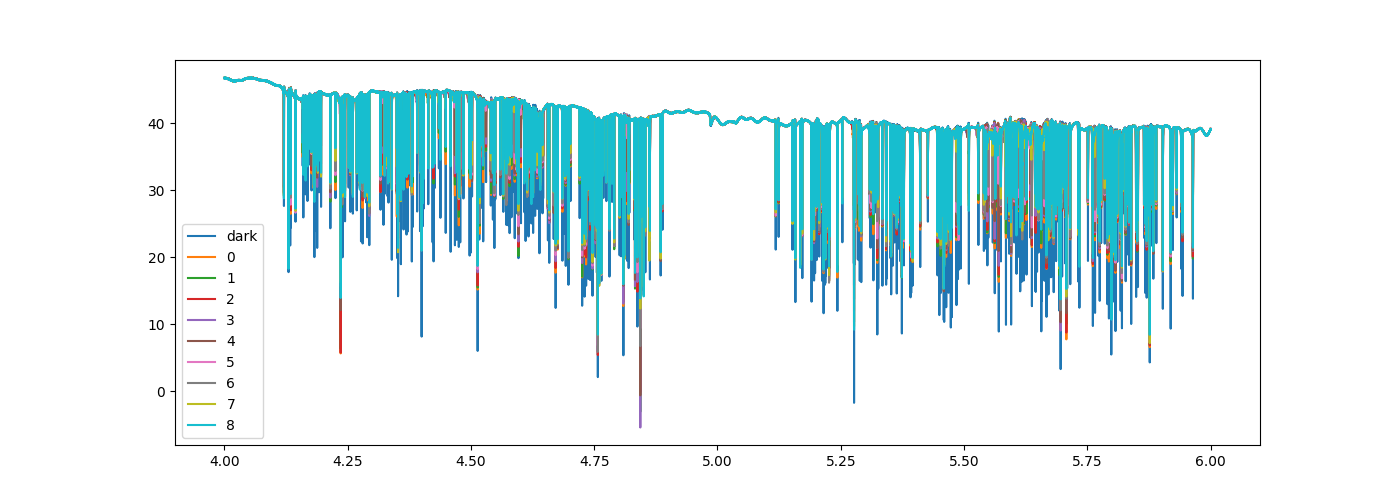

In [91]:
dim = 1
start = 11
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(freqs, s21dark, label='dark')
num=9
for i in range(num):
    ax.plot(freqs, s21s[start+i, dim, :], label='%d' % i)
ax.legend()

502


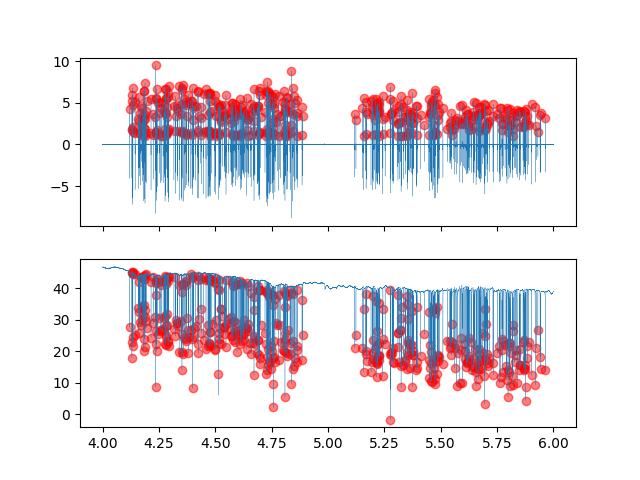

In [27]:
y = s21dark
width = 2
smoothed_y = moving_average_filter(y, width)
first_diff_y = np.diff(smoothed_y, 1)
smoothed_first_diff_y = moving_average_filter(first_diff_y, width)
sec_diff_y = np.diff(smoothed_first_diff_y, width)
smoothed_sec_diff_y = moving_average_filter(sec_diff_y, width)

pks, props = find_peaks(smoothed_sec_diff_y, height=1, prominence=1)
print(len(pks))
heights = props['peak_heights']
fig, ax = plt.subplot_mosaic('a;b', sharex=True)
ax['a'].plot(freqs[1:-2], smoothed_sec_diff_y, lw=.2)
ax['a'].scatter(freqs[1:-1][pks], heights, color='r', alpha=0.5)
ax['b'].plot(freqs[1:-1], y[1:-1], lw=.2)
# ax['b'].plot(freqs[1:-1], smoothed_y[1:-1], lw=0.2)
ax['b'].scatter(freqs[1:-1][pks], y[1:-1][pks], color='r', alpha=0.5)
plt.show()

In [ ]:
y1 = s21s[0, 0, :]
y2 = s21s[1, 0, :]

nr_scans, nr_dims, len_s21 = s21s.shape

for i in range(nr_scans):
    
for j in range(nr_scans):
    
# Plot
fig, ax = plt.subplots()
ax.plot(freqs, s21dark)
ax.plot(freqs, y1)
ax.plot(freqs, y2)
# plt.xlim(4.22,4.23)
plt.show()